# DINOv2
* This notebook is modified from https://github.com/MartinBurian/dinov2/blob/experiments/experiments/fg_segmantation.ipynb
* [PCA tutorial](https://www.geeksforgeeks.org/principal-component-analysis-pca/)

The PCA visuzalition process is illustraed in DINOv2 paper pp. 17:
> **PCA of patch features.** We show the results of the principal component analysis (PCA) performed on the patch features extracted by our model. We keep only patches with a positive value after we threshold the first component. This procedure turns out to separate the image’s main object from the background. We compute a second PCA on the remaining patches across three images depicting the same category. We color the three first components with three different colors and present the results in Fig. 1 and 9.

## Prepare model

There are two options to load the model:
**Load model with weights from PyTorch hub** - does not work for CPU, because the model uses attention layer with CUDA-only implementation
**Use the model from this repo, with externally downloaded weights** - works after a few tweaks
  - in vision_transformer.py, change the attention layer to ordinary Attention
  - remove `.cuda()` in `setup.py`
Load only the desired model in the cells below

Model details, see [model card](https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md):
  - ViT-S (21M params): Patch size 14, embedding dimension 384, 6 heads, MLP FFN
  - ViT-B (86M params): Patch size 14, embedding dimension 768, 12 heads, MLP FFN
  - ViT-L (0.3B params): Patch size 14, embedding dimension 1024, 16 heads, MLP FFN
  - ViT-g (1.1B params): Patch size 14, embedding dimension 1536, 24 heads, SwiGLU FFN

In [20]:
import sys
import os
import torch

# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust path if your notebook is deeper in directories

# Add project root to sys.path
sys.path.append(project_root)

# Now you can import dinov2
import dinov2
from dinov2.eval.setup import build_model_for_eval
from dinov2.configs import load_and_merge_config

device = "cuda"
device = torch.device(device if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
threshold = 0.7

In [22]:
# Download checkpoints 
# import torch

# # DINOv2
# # dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
# # dinov2_vitb14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_lc')
# dinov2_vitl14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_lc')
# dinov2_vitg14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_lc')

# Then move ckpts to dinov2/checkpoints` 

In [23]:
# BASE
conf = load_and_merge_config('eval/vitb14_pretrain')
model = build_model_for_eval(conf, '../dinov2/checkpoints/dinov2_vitb14_pretrain.pth')

We use size=LARGE

In [24]:
# # LARGE
# conf = load_and_merge_config('eval/vitl14_pretrain')
# model = build_model_for_eval(conf, '../dinov2/checkpoints/dinov2_vitl14_pretrain.pth')

In [25]:
# # GIANT
# conf = load_and_merge_config('eval/vitg14_pretrain')
# model = build_model_for_eval(conf, '../dinov2_vitg14_pretrain.pth')

## Try it out

Load a set of training images

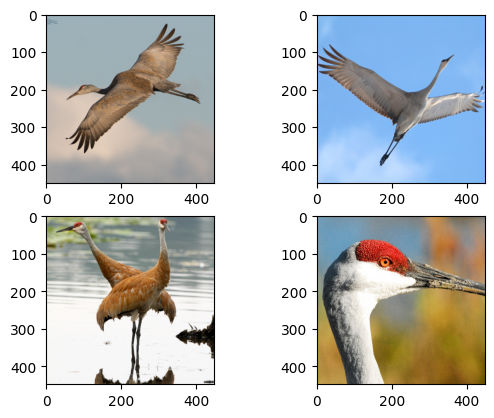

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import torchvision.transforms as tt

images = []

for i in range(1,5):
    image = cv2.imread(f"./data/crane/crane{i}.jpg");
    image = cv2.resize(image, (448,448))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32')/255
    images.append(image)
    plt.subplot(220+i)
    plt.imshow(image)

# The array of loaded images is [batch, height, width, channel]
# We need to reorder the images to [batch, channel, height, width]
images_arr = np.stack(images)
input_tensor = torch.Tensor(np.transpose(images_arr, [0, 3, 1, 2]))

transform = tt.Compose([tt.Normalize(mean=0.5, std=0.2)])

input_tensor = transform(input_tensor).to(device)

Before forward pass, we first explore the imge size, patch size, embedding size and patch resolution (patch number)

In [27]:
B, C, H, W = input_tensor.shape  # Batch size, Height, Width, Channels
print(f"Input tensor shape: Batch={B}, Height={H}, Width={W}, Channels={C}")

patch_size = model.patch_size  # For DINO models, the patch size is often 14 (check the model card)
print(f"Patch size: {patch_size}")

embedding_dim = model.embed_dim  # Embedding dimension of the patch embeddings
print(f"Embedding dimension: {embedding_dim}")

patch_resolution = (H // patch_size) * (W // patch_size)  # Total number of patches
print(f"Number of patches of each image: {patch_resolution}")

Input tensor shape: Batch=4, Height=448, Width=448, Channels=3
Patch size: 14
Embedding dimension: 768
Number of patches of each image: 1024


Pass the images through the DINOv2 model, and grab the outputs

We can use either the normalized patch tokens, or the full pre-normalized output, they give very similar results

In [28]:
result = model.forward_features(input_tensor)


In [29]:
patch_embeddings = result['x_norm_patchtokens'].detach().cpu().numpy().reshape([B,patch_resolution,embedding_dim])

# patch_tokens = result['x_prenorm'].detach().numpy().reshape([4,1025,-1])
# patch_embeddings = patch_embeddings[:,1:,:]
print(patch_embeddings.shape) # (B, patch_resolution, embedding_dim)

(4, 1024, 768)


Then, we can build a linear model over the patch tokens. We can segment the foreground object by building a simple linear classifier over the patch tokens: we compute the first component of the PCA and scale and threshold the output.

We perform first PCA with one component and apply a threshold to extract the foregound patches, i.e., patches representing the foreground objects.

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

fg_pca = PCA(n_components=1)

masks=[]
plt.figure(figsize=(10,10))

all_patch_embeddings = patch_embeddings.reshape([-1,embedding_dim]) # (B*patch_resolution, embedding_dim)
reduced_patch_embeddings = fg_pca.fit_transform(all_patch_embeddings)# Reduced to dimension=1, i.e., (B*patch_resolution, 1)
reduced_patch_embeddings = minmax_scale(reduced_patch_embeddings) # standardize the data, see https://www.geeksforgeeks.org/normalization-vs-standardization/
reduced_patch_embeddings = reduced_patch_embeddings.reshape((B,patch_resolution)) # (B, patch_resolution)

for i in range(B):
    # choose a threshold to segment the foreground
    mask = (reduced_patch_embeddings[i] > threshold).ravel() # threshold = 0.6
    masks.append(mask)

# extract foreground patches
nums_of_fg_patches = [np.sum(m) for m in masks]
fg_patch_embeddings = np.vstack([patch_embeddings[i, m, :] for i, m in enumerate(masks)]) # (total_foreground_patches, embedding_dim)

for i, num_patches in enumerate(nums_of_fg_patches):
    print(f"Num of foreground patches of image {i}: {num_patches}")

total_foreground_patches = sum(nums_of_fg_patches)
print(f"Total num of foreground patches: {total_foreground_patches}")


Num of foreground patches of image 0: 250
Num of foreground patches of image 1: 255
Num of foreground patches of image 2: 268
Num of foreground patches of image 3: 379
Total num of foreground patches: 1152


<Figure size 1000x1000 with 0 Axes>

We can see that the foregound objects are:

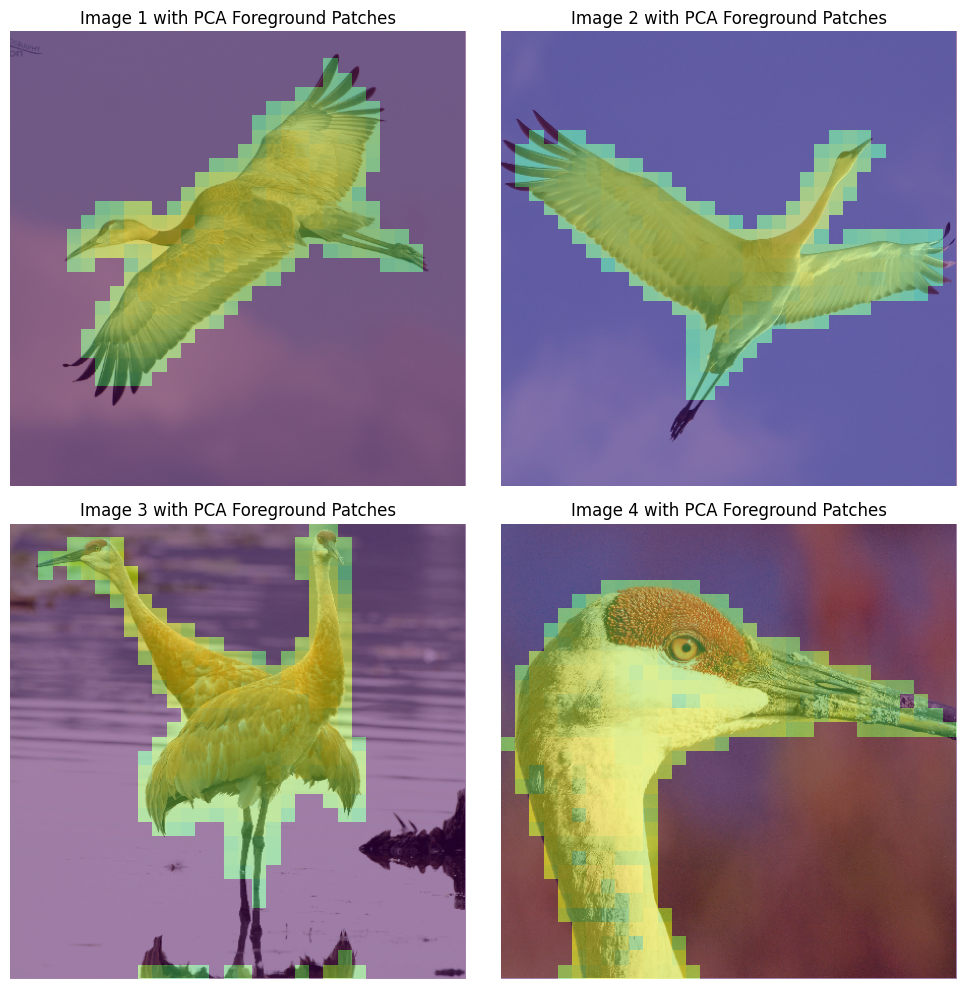

In [38]:
plt.figure(figsize=(10, 10))

for i, (image, mask) in enumerate(zip(images, masks)):
    masked_patches = np.where(mask, reduced_patch_embeddings[i], 0.0)  # We only colorize masked patches, i.e., foreground patches
    patch_map = masked_patches.reshape(H // patch_size, W // patch_size)  # Reshape for plotting

    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(patch_map, extent=(0, W, H, 0), alpha=0.5)  # Overlay with flipped Y-axis
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.title(f"Image {i+1} with PCA Foreground Patches")

plt.tight_layout()
plt.show()

Afterwards, we run a second PCA with three components, corresponding to three different color channels, on the foreground patches. This gives us fine-grained details of the foregound objects.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


Explained variance ratio by PCA components: [0.1334477  0.0838941  0.07562712]


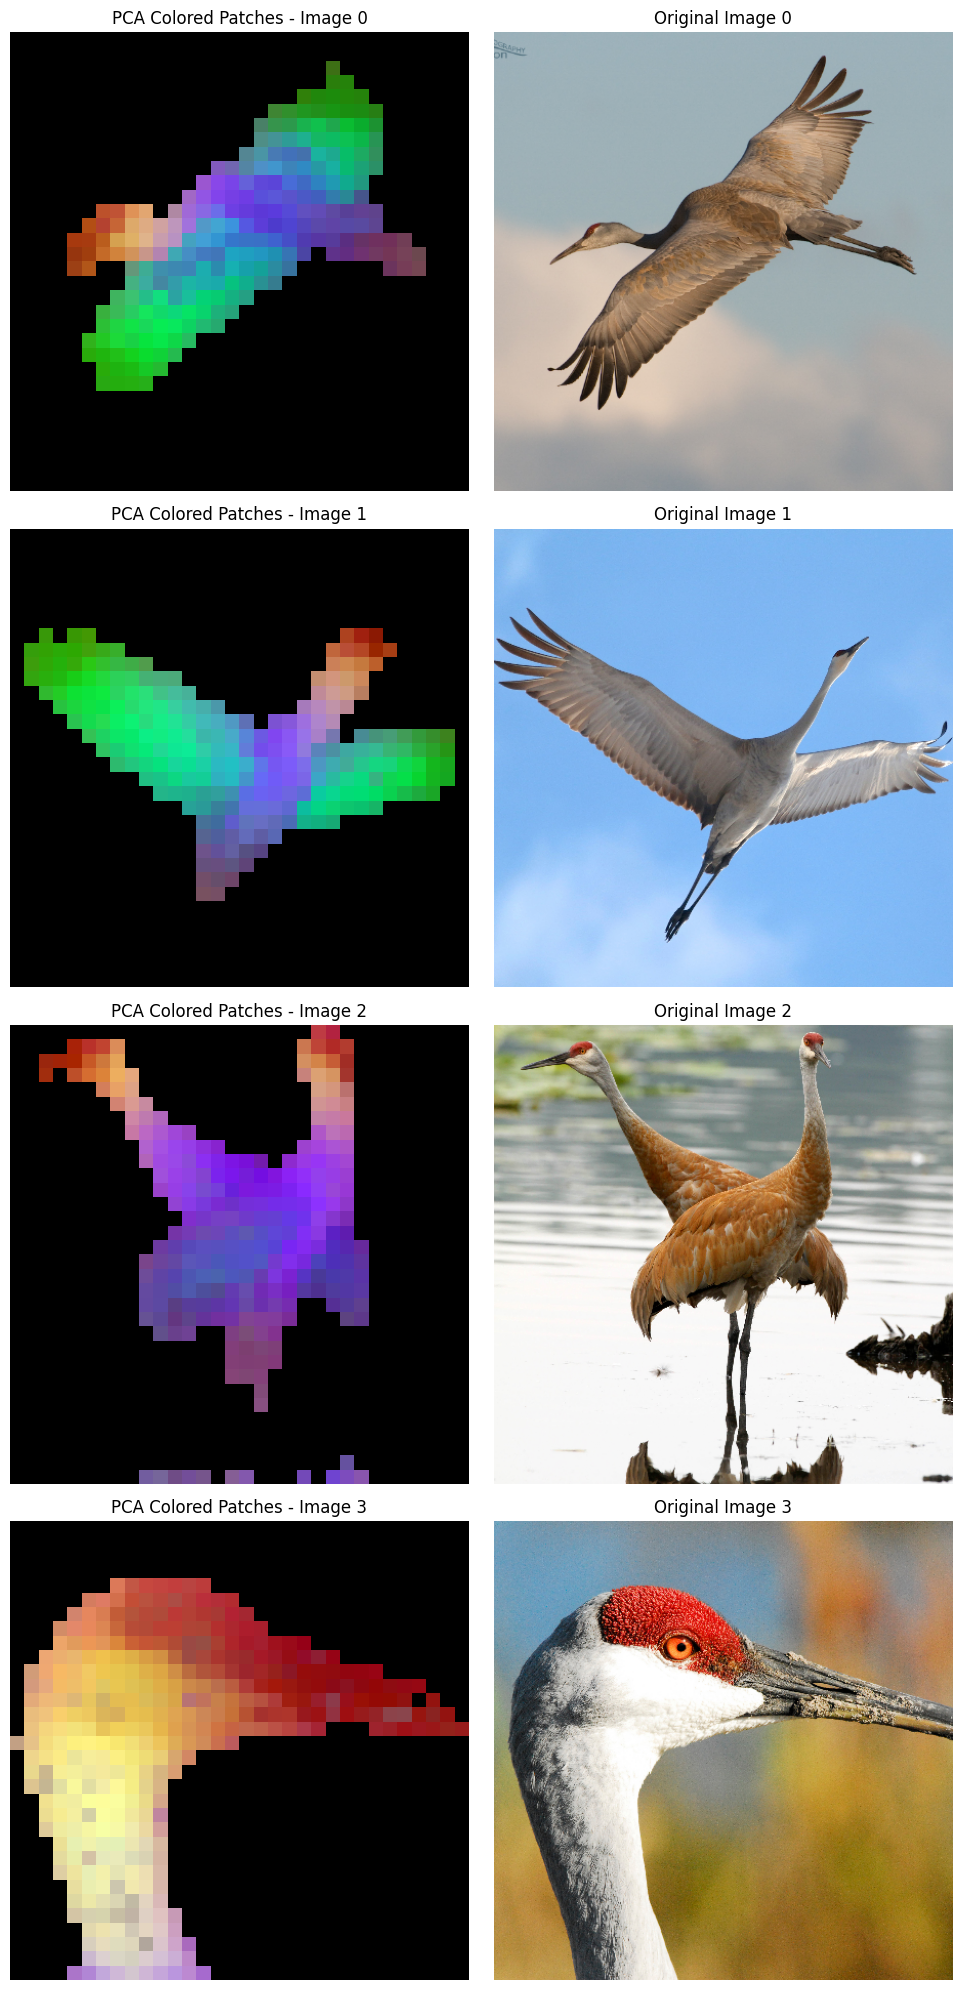

In [40]:

object_pca = PCA(n_components=3)

# Fit PCA to all foreground patch embeddings
reduced_fg_patch_embeddings = object_pca.fit_transform(fg_patch_embeddings)# # (total_foreground_patches, 3)
reduced_fg_patch_embeddings = minmax_scale(reduced_fg_patch_embeddings)  # Scale to (0,1)

print("Explained variance ratio by PCA components:", object_pca.explained_variance_ratio_)

plt.figure(figsize=(10, 20))

start_idx = 0  # Track the start index for each image
for i, mask in enumerate(masks):
    num_patches = nums_of_fg_patches[i]  # Number of foreground patches for image i

    # Assign PCA-reduced embeddings to corresponding patches
    patch_image = np.zeros((patch_resolution, C), dtype='float32')
    patch_image[mask, :] = reduced_fg_patch_embeddings[start_idx:start_idx + num_patches, :]

    start_idx += num_patches  # Move the start index to the next image’s fg patches

    # Reshape and transpose for visualization
    color_patches = patch_image.reshape((H // patch_size, W // patch_size, C))
    plt.subplot(4, 2, 1 + 2 * i)
    plt.imshow(color_patches)
    plt.axis('off')
    plt.title(f"PCA Colored Patches - Image {i}")

    plt.subplot(4, 2, 2 + 2 * i)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Original Image {i}")

plt.tight_layout()
plt.show()


## Test

We try the PCA features on an unknown image of another crane.

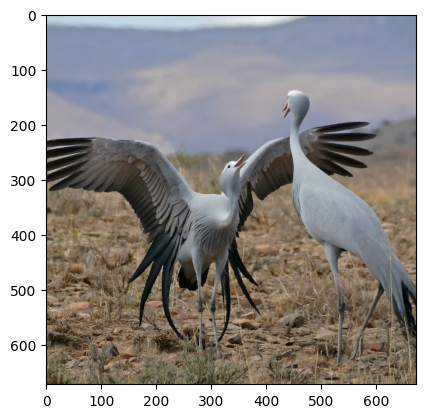

In [41]:
test_image = cv2.imread(f"./data/crane/crane_test.jpg");
test_image = cv2.resize(test_image, (672,672))  # unicorn: 224,280
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = test_image.astype('float32')/255

plt.imshow(test_image)

test_images = [test_image]

test_images_arr = np.stack(test_images)
test_tensor = torch.Tensor(np.transpose(test_images_arr, [0, 3, 2, 1]))
test_tensor = transform(test_tensor).to(device)

In [34]:
test_result = model.forward_features(test_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


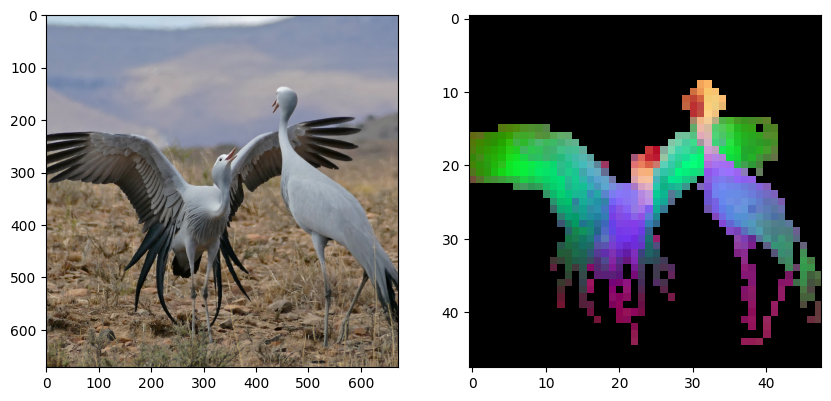

In [35]:
test_patch_tokens = test_result['x_norm_patchtokens'].detach().cpu().numpy().reshape([2304, -1])
fg_result = fg_pca.transform(test_patch_tokens)
fg_result = minmax_scale(fg_result)

fg_mask = (fg_result > 0.5)

object_result = object_pca.transform(test_patch_tokens)
object_result = minmax_scale(object_result)

only_object = np.zeros_like(object_result)
only_object[fg_mask.ravel(), :] = object_result[fg_mask.ravel(), :]

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(test_image)
plt.subplot(122)
plt.imshow(only_object.reshape([48, -1, 3]).transpose([1, 0, 2]))

These results are very impressive, the model generalized from 4 images with only a linear model built on top.
The results may be biased because we used readily available images from the internet/wikipedia, that were probably part of the pre-training. We should test it with some custom images later.

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import numpy as np


